In [1]:
import os
import time
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
import torchvision.transforms as T
from torchvision.models import vgg16


from vae_v4.model import ResNet_VAE
from vae_v4.dataset import TrashDataset

In [2]:
INPUT_DIM=64*64
Z_DIM = 10
NUM_EPOCHS=120
BATCH_SIZE=32
LA_REATE = 0.00015
SAVE_MODEL_ITTR=10
SAVE_MODEL_PATH= "./vae_v4_saved_models"
DEVICE="cuda"
CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 1024
CNN_embed_dim = 256     # latent dim extracted by 2D CNN
res_size = 224        # ResNet image size
dropout_p = 0.2       # dropout probability


In [3]:
train_transform = T.Compose(
    [
        T.Resize((res_size, res_size)),
        T.RandomHorizontalFlip(p=0.4),
        T.RandomGrayscale(),
        T.RandomAutocontrast(),
        # A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        # A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        # A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        T.ToTensor(),
    ]
)
test_transform = T.Compose(
    [T.Resize((res_size, res_size)), T.ToTensor()]
)

In [4]:
train_dataset = TrashDataset("../student_db",train=True, transform=train_transform, grayscale = False, subset=True)
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE, shuffle=True) 

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 416 tasks      | elapsed:    1.6s


[Parallel(n_jobs=8)]: Done 1816 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done 3216 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done 5016 tasks      | elapsed:    6.2s
[Parallel(n_jobs=8)]: Done 6816 tasks      | elapsed:    7.7s
[Parallel(n_jobs=8)]: Done 9016 tasks      | elapsed:    9.5s
[Parallel(n_jobs=8)]: Done 11216 tasks      | elapsed:   11.2s
[Parallel(n_jobs=8)]: Done 13044 tasks      | elapsed:   14.0s
[Parallel(n_jobs=8)]: Done 13521 tasks      | elapsed:   14.3s
[Parallel(n_jobs=8)]: Done 14398 tasks      | elapsed:   14.6s
[Parallel(n_jobs=8)]: Done 14696 tasks      | elapsed:   14.7s
[Parallel(n_jobs=8)]: Done 14815 tasks      | elapsed:   14.8s
[Parallel(n_jobs=8)]: Done 14934 tasks      | elapsed:   14.9s
[Parallel(n_jobs=8)]: Done 15000 out of 15000 | elapsed:   14.9s finished


In [5]:
model = ResNet_VAE(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim).to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
def loss_function(x_hat, x, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

optimizer = optim.Adam(model.parameters(), lr=LA_REATE)
loss_fn = loss_function

In [7]:
vgg_model_r = vgg16(pretrained=True).to(DEVICE)
conv1r = vgg_model_r.features[:2]
conv2r = vgg_model_r.features[:7]
conv3r = vgg_model_r.features[:12]

img = train_dataset[0]["img"].unsqueeze(0)

def loss_function_1(x_hat, x, mean, log_var):
    alpha = 1
    beta = 0.5
    ### calculate perception loss
    r1=conv1r(x)
    r2=conv2r(x)
    r3=conv3r(x)

    g1=conv1r(x_hat)
    g2=conv2r(x_hat)
    g3=conv3r(x_hat)

    l1_loss = torch.sum(torch.pow((r1-g1),2),dim=[1,2,3])
    l2_loss = torch.sum(torch.pow((r2-g2),2),dim=[1,2,3])
    l3_loss = torch.sum(torch.pow((r3-g3),2),dim=[1,2,3])

    pct_loss = torch.mean(l1_loss + l2_loss + l3_loss)

    ### calculate KL loss
    kl_loss = torch.mean(- 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp()))

    ### calculate total loss
    return torch.add(beta * pct_loss, alpha * kl_loss)

loss_fn = loss_function_1

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
model.train()
epoch_train_losses = []
for epoch in range(NUM_EPOCHS):

    losses = []
    all_y, all_z, all_mu, all_logvar = [], [], [], []

    batch = tqdm(enumerate(train_loader))
    for idx, data in batch:
        # Forward pass
        x = data["img"].float().to(DEVICE)
        recunstructed_img, code_output, mean, logvar = model(x)

        # Compute loss
        recunstructed_loss = loss_fn(recunstructed_img, x, mean, logvar)

        # Backprop
        optimizer.zero_grad()
        recunstructed_loss.backward()
        optimizer.step()

        losses.append(recunstructed_loss.item())

        all_z.extend(code_output.data.cpu().numpy())
        all_mu.extend(mean.data.cpu().numpy())
        all_logvar.extend(logvar.data.cpu().numpy())



        batch.set_postfix(loss=recunstructed_loss.item())

    epoch_train_losses.append(losses)
    if (epoch+1) % SAVE_MODEL_ITTR == 0:
        torch.save(model.state_dict(), os.path.join(SAVE_MODEL_PATH, 'model_epoch_full{}.pth'.format(epoch + 1)))  # save motion_encoder
        print("Epoch {} model saved!".format(epoch + 1))
    

469it [02:02,  3.83it/s, loss=1.4e+6] 
469it [02:02,  3.83it/s, loss=1.48e+6]
469it [02:02,  3.83it/s, loss=1.63e+6]
469it [02:02,  3.83it/s, loss=1.31e+6]
469it [02:02,  3.82it/s, loss=1.44e+6]
469it [02:02,  3.83it/s, loss=1.36e+6]
469it [02:02,  3.83it/s, loss=1.51e+6]
469it [02:02,  3.82it/s, loss=1.27e+6]
469it [02:02,  3.82it/s, loss=1.42e+6]
469it [02:02,  3.83it/s, loss=1.24e+6]


Epoch 10 model saved!


469it [02:02,  3.83it/s, loss=1.63e+6]
469it [02:02,  3.83it/s, loss=1.61e+6]
469it [02:02,  3.83it/s, loss=1.28e+6]
469it [02:02,  3.83it/s, loss=1.58e+6]
469it [02:02,  3.83it/s, loss=1.47e+6]
469it [02:02,  3.83it/s, loss=1.47e+6]
469it [02:02,  3.83it/s, loss=1.66e+6]
469it [02:02,  3.83it/s, loss=1.27e+6]
469it [02:02,  3.82it/s, loss=1.31e+6]
469it [02:02,  3.83it/s, loss=1.38e+6]


Epoch 20 model saved!


469it [02:02,  3.82it/s, loss=1.3e+6] 
469it [02:02,  3.82it/s, loss=1.48e+6]
469it [02:02,  3.83it/s, loss=1.21e+6]
469it [02:02,  3.82it/s, loss=1.3e+6] 
469it [02:02,  3.83it/s, loss=1.6e+6] 
469it [02:02,  3.83it/s, loss=1.45e+6]
469it [02:02,  3.83it/s, loss=1.43e+6]
469it [02:02,  3.83it/s, loss=1.32e+6]
469it [02:02,  3.83it/s, loss=1.36e+6]
469it [02:02,  3.83it/s, loss=1.46e+6]


Epoch 30 model saved!


469it [02:02,  3.83it/s, loss=1.27e+6]
469it [02:02,  3.83it/s, loss=1.14e+6]
469it [02:02,  3.83it/s, loss=1.47e+6]
469it [02:02,  3.83it/s, loss=1.4e+6] 
469it [02:02,  3.83it/s, loss=1.39e+6]
469it [02:02,  3.83it/s, loss=1.4e+6] 
469it [02:02,  3.82it/s, loss=1.38e+6]
469it [02:02,  3.82it/s, loss=1.28e+6]
469it [02:02,  3.83it/s, loss=1.22e+6]
469it [02:02,  3.83it/s, loss=1.33e+6]


Epoch 40 model saved!


469it [02:02,  3.83it/s, loss=1.52e+6]
469it [02:02,  3.83it/s, loss=1.27e+6]
469it [02:02,  3.83it/s, loss=1.27e+6]
469it [02:02,  3.83it/s, loss=1.34e+6]
469it [02:02,  3.83it/s, loss=1.47e+6]
469it [02:02,  3.83it/s, loss=1.28e+6]
469it [02:02,  3.83it/s, loss=1.35e+6]
469it [02:02,  3.83it/s, loss=1.31e+6]
469it [02:02,  3.83it/s, loss=1.11e+6]
469it [02:02,  3.82it/s, loss=1.07e+6]


Epoch 50 model saved!


469it [02:02,  3.83it/s, loss=1.27e+6]
469it [02:02,  3.83it/s, loss=1.4e+6] 
469it [02:02,  3.82it/s, loss=1.33e+6]
469it [02:02,  3.83it/s, loss=1.39e+6]
469it [02:02,  3.83it/s, loss=1.4e+6] 
469it [02:02,  3.83it/s, loss=1.15e+6]
469it [02:02,  3.83it/s, loss=1.23e+6]
469it [02:02,  3.83it/s, loss=1.17e+6]
469it [02:02,  3.83it/s, loss=1.3e+6] 
469it [02:02,  3.83it/s, loss=1.37e+6]


Epoch 60 model saved!


469it [02:02,  3.83it/s, loss=1.32e+6]
469it [02:02,  3.83it/s, loss=1.25e+6]
469it [02:02,  3.83it/s, loss=1.27e+6]
469it [02:02,  3.83it/s, loss=1.25e+6]
469it [02:02,  3.83it/s, loss=1.37e+6]
469it [02:02,  3.83it/s, loss=1.41e+6]
469it [02:02,  3.83it/s, loss=1.34e+6]
469it [02:02,  3.83it/s, loss=1.42e+6]
469it [02:02,  3.83it/s, loss=1.49e+6]
469it [02:02,  3.83it/s, loss=1.6e+6] 


Epoch 70 model saved!


469it [02:02,  3.83it/s, loss=1.24e+6]
469it [02:02,  3.83it/s, loss=1.43e+6]
469it [02:02,  3.83it/s, loss=1.43e+6]
469it [02:02,  3.83it/s, loss=1.27e+6]
469it [02:02,  3.83it/s, loss=1.43e+6]
469it [02:02,  3.83it/s, loss=1.33e+6]
469it [02:02,  3.83it/s, loss=1.21e+6]
469it [02:02,  3.83it/s, loss=1.47e+6]
469it [02:02,  3.84it/s, loss=1.57e+6]
469it [02:02,  3.84it/s, loss=1.16e+6]


Epoch 80 model saved!


469it [02:02,  3.83it/s, loss=1.19e+6]
469it [02:02,  3.83it/s, loss=1.58e+6]
469it [02:02,  3.83it/s, loss=1.35e+6]
469it [02:02,  3.83it/s, loss=1.52e+6]
469it [02:02,  3.83it/s, loss=1.41e+6]
469it [02:02,  3.83it/s, loss=1.31e+6]
469it [02:02,  3.83it/s, loss=1.36e+6]
469it [02:02,  3.83it/s, loss=1.34e+6]
469it [02:02,  3.83it/s, loss=1.27e+6]
469it [02:02,  3.83it/s, loss=1.35e+6]


Epoch 90 model saved!


469it [02:02,  3.83it/s, loss=1.21e+6]
469it [02:02,  3.83it/s, loss=1.27e+6]
469it [02:02,  3.83it/s, loss=1.28e+6]
469it [02:02,  3.83it/s, loss=1.33e+6]
469it [02:02,  3.83it/s, loss=1.3e+6] 
469it [02:02,  3.83it/s, loss=1.42e+6]
469it [02:02,  3.83it/s, loss=1.28e+6]
469it [02:02,  3.83it/s, loss=1.49e+6]
469it [02:02,  3.83it/s, loss=1.3e+6] 
469it [02:02,  3.83it/s, loss=1.32e+6]


Epoch 100 model saved!


469it [02:02,  3.83it/s, loss=1.33e+6]
469it [02:02,  3.83it/s, loss=1.34e+6]
469it [02:02,  3.83it/s, loss=1.25e+6]
469it [02:02,  3.83it/s, loss=1.27e+6]
469it [02:02,  3.83it/s, loss=1.24e+6]
469it [02:02,  3.83it/s, loss=1.32e+6]
469it [02:02,  3.83it/s, loss=1.44e+6]
469it [02:02,  3.83it/s, loss=1.3e+6] 
469it [02:02,  3.83it/s, loss=1.29e+6]
469it [02:02,  3.83it/s, loss=1.18e+6]


Epoch 110 model saved!


469it [02:02,  3.83it/s, loss=1.39e+6]
469it [02:02,  3.83it/s, loss=1.49e+6]
469it [02:02,  3.83it/s, loss=1.19e+6]
469it [02:02,  3.83it/s, loss=1.24e+6]
469it [02:02,  3.83it/s, loss=1.02e+6]
469it [02:02,  3.83it/s, loss=1.56e+6]
469it [02:02,  3.83it/s, loss=1.25e+6]
469it [02:02,  3.83it/s, loss=1.15e+6]
469it [02:02,  3.83it/s, loss=1.21e+6]
469it [02:02,  3.83it/s, loss=1.29e+6]


Epoch 120 model saved!


In [7]:
model.eval()
train_img1 = train_dataset[0]["img"]
train_img1 = train_img1.unsqueeze(0)
recunstructed_img, code_output, mean, logvar = model(train_img1.to(DEVICE))    

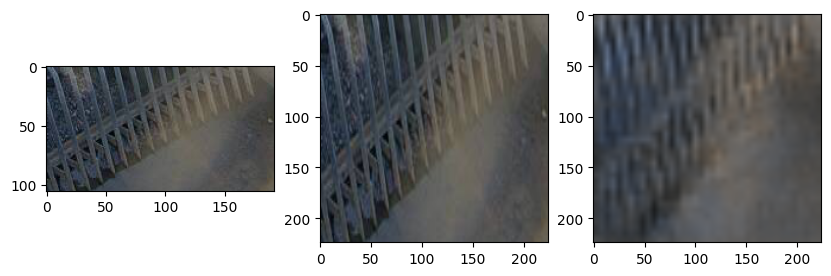

In [8]:
fig, axes = plt.subplots(1,3, figsize=(10,6))
x = np.transpose(train_img1[0], (1, 2, 0))
x_hat = np.transpose(recunstructed_img[0].cpu().detach().numpy(), (1, 2, 0))
img = Image.open(train_dataset[0]["path"]).convert('RGB')
axes[0].imshow(img)
axes[1].imshow(x)
axes[2].imshow(x_hat)
plt.show()

In [9]:
BATCH_SIZE=1
test_dataset = TrashDataset("../student_db",train=False, transform=None, grayscale = False, subset=False)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE, shuffle=True) 

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 416 tasks      | elapsed:    0.9s


[Parallel(n_jobs=8)]: Done 1816 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 2472 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 2784 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 2910 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 3064 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 3404 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 3772 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 4140 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 4400 out of 4400 | elapsed:    2.7s finished


In [ ]:
def tensor2img(image, imtype=np.uint8):
    if not isinstance(image, np.ndarray):
        if isinstance(image, torch.Tensor):
            image = image.data
        else:
            return image
        image = image.cpu().numpy()
        assert len(image.squeeze().shape) < 4
    # if image.dtype != np.uint8:
    #     image = (np.transpose(image.squeeze(), (1, 2, 0)) * 0.5 + 0.5) * 255
    image = np.transpose(image.squeeze(), (1, 2, 0)) * 255
    return image.astype(imtype)


def compare_images(real_img, generated_img, threshold=0.4):
    generated_img = generated_img.type_as(real_img)
    diff_img = np.abs((generated_img - real_img).cpu().detach().numpy())
    real_img = tensor2img(real_img)
    generated_img = tensor2img(generated_img)
    diff_img = tensor2img(diff_img)

    threshold = threshold*255
    diff_img[diff_img <= threshold] = 0

    anomaly_img = np.zeros_like(real_img)
    print("anomaly_img: ", anomaly_img.shape)
    anomaly_img[:, :, :] = real_img
    anomaly_img[np.where(diff_img>0)[0], np.where(diff_img>0)[1]] = [200, 0, 0]
    
    return tensor2img(anomaly_img) , (real_img, generated_img, diff_img, anomaly_img)

torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
anomaly_img:  (224, 224, 3)


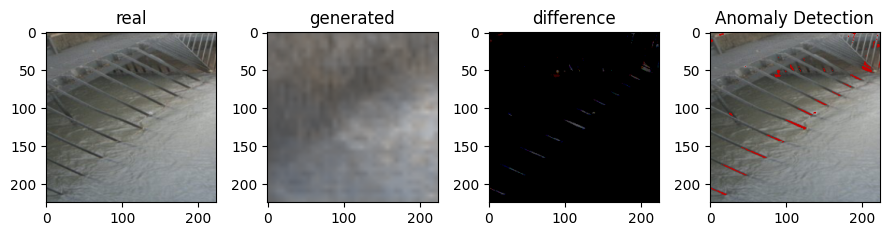

torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
anomaly_img:  (224, 224, 3)


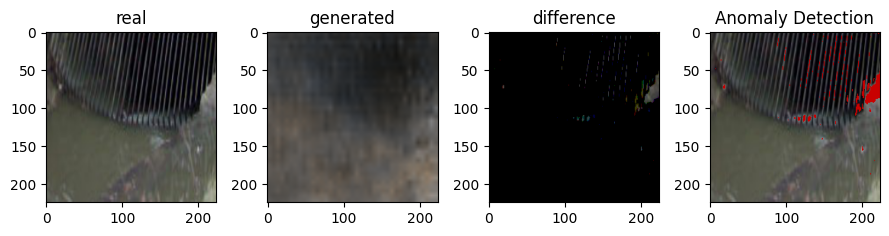

torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
anomaly_img:  (224, 224, 3)


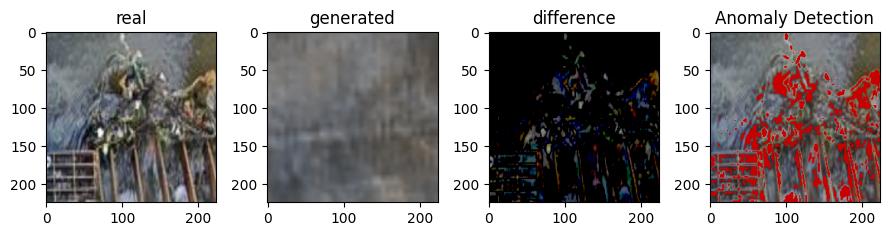

torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
anomaly_img:  (224, 224, 3)


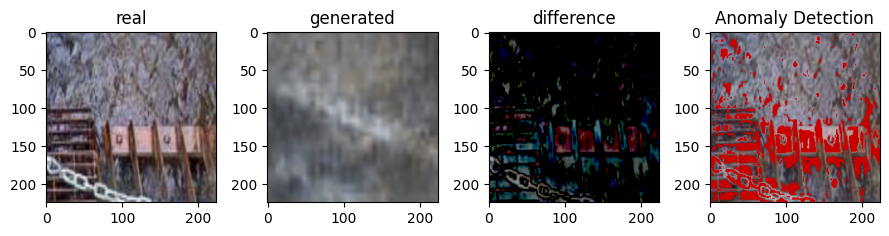

torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
anomaly_img:  (224, 224, 3)


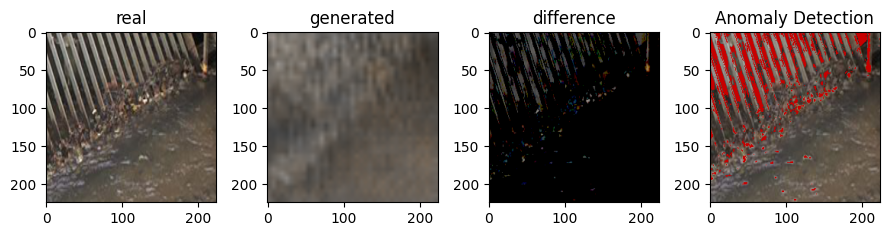

torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
anomaly_img:  (224, 224, 3)


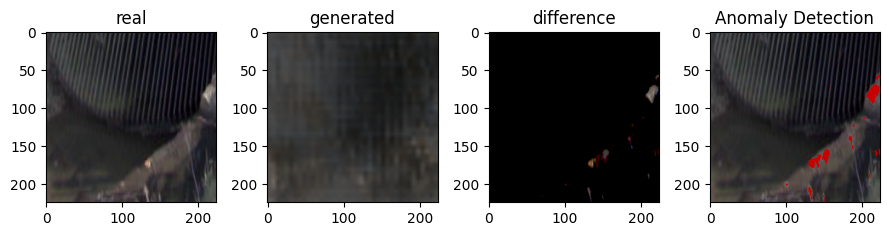

torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
anomaly_img:  (224, 224, 3)


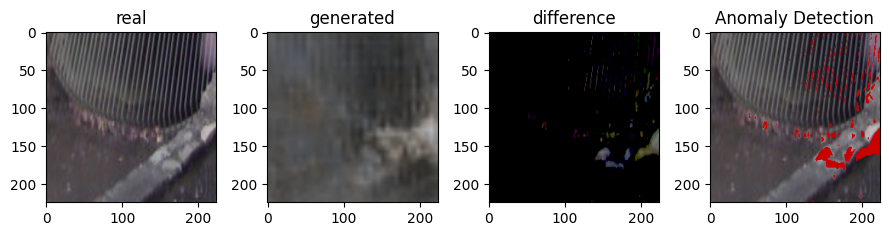

torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
anomaly_img:  (224, 224, 3)


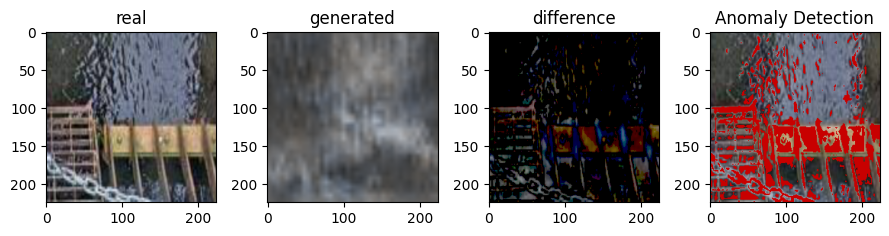

torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
anomaly_img:  (224, 224, 3)


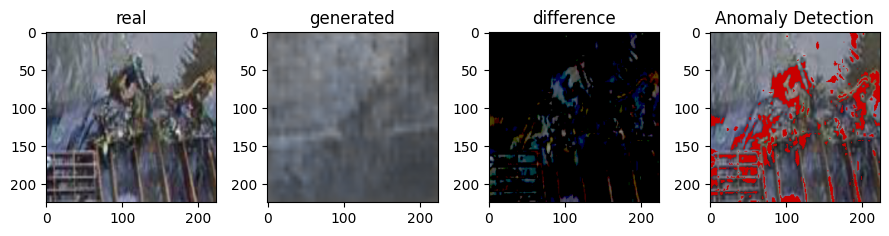

torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
anomaly_img:  (224, 224, 3)


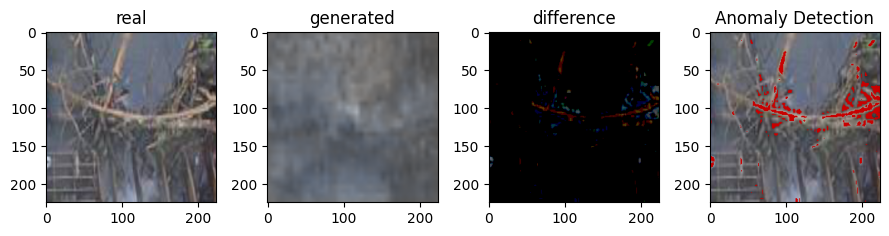

end Test


In [37]:
model.eval()                    # model eval version
for data in np.random.choice(list(test_loader),10, replace=False):
    # data = loaded_dataset[random.randint(0,len(loaded_dataset))]
    epoch_start_time = time.time()
    x = data['img'].to(DEVICE)
    x_hat, code_output, mean, logvar = model(x)
    epoch_time = time.time() - epoch_start_time
    # print(f"{i} epoch_time : {epoch_time:.3f}")
    print(x.shape, x_hat.shape)
    #=============================================
    anomaly_img, plt_img = compare_images(x, x_hat,threshold=0.2)
    fig, plots = plt.subplots(1, 4)
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(plt_img[0], label="real")
    plots[1].imshow(plt_img[1])
    plots[2].imshow(plt_img[2])
    plots[3].imshow(plt_img[3])

    plots[0].set_title("real")
    plots[1].set_title("generated")
    plots[2].set_title("difference")
    plots[3].set_title("Anomaly Detection")
    # plt.savefig(os.path.join(paths, "plt"+data["path"][0].split("/")[-1]))
    plt.show()
#=============================================
    
print("end Test")

In [4]:
BATCH_SIZE=50
test_dataset = TrashDataset("../student_db",train=False, transform=test_transform, grayscale = False, subset=False)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE, shuffle=True) 

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    0.1s


[Parallel(n_jobs=8)]: Done 416 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 1816 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 3216 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 5016 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done 6620 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done 7252 tasks      | elapsed:    4.9s
[Parallel(n_jobs=8)]: Done 7296 tasks      | elapsed:    4.9s
[Parallel(n_jobs=8)]: Done 7348 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done 7400 tasks      | elapsed:    5.1s
[Parallel(n_jobs=8)]: Done 7460 tasks      | elapsed:    5.1s
[Parallel(n_jobs=8)]: Done 7912 tasks      | elapsed:    5.2s
[Parallel(n_jobs=8)]: Done 7980 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 8400 out of 8400 | elapsed:    5.7s finished


#### Validation with models trained for different epochs (ignorance_threshold = 0.2)

In [37]:
def run_validation(ignorance_threshold=0.2, threshold=4000):
    all_actual_predictions = {}
    all_diffs_categorized = {}
    all_diffs ={}

    epochs = [40,50,60,70,80,90,100,110,120]

                    # model eval version
    for epoch in epochs:

        print("testing for model: ", SAVE_MODEL_PATH+f"/model_epoch_full{epoch}.pth")
        model = ResNet_VAE(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim)
        model.load_state_dict(torch.load(SAVE_MODEL_PATH+f"/model_epoch_full{epoch}.pth"))
        model = model.to(DEVICE)
        model.eval()  

        predictions = []
        actual = []
        all_diffs_per_epoch = defaultdict(list)
        all_diffs_in_epoch = []
    
        for idx, data in tqdm(enumerate(test_loader)):
            # data = loaded_dataset[random.randint(0,len(loaded_dataset))]
            epoch_start_time = time.time()
            x = data['img'].to(DEVICE)
            x_hat, code_output, mean, logvar = model(x)
            epoch_infrence_time = time.time() - epoch_start_time

            for i in range(data["img"].shape[0]):
                diff_img = np.abs(data["img"][i].numpy() - x_hat[i].cpu().detach().numpy())
                diff_img[diff_img < ignorance_threshold] = 0
                diff = np.sum(diff_img)

                if diff < threshold:
                    predictions.append("notrash")
                else:
                    predictions.append("trash")
                # print(data["path"])
                if "notrash"in data["path"][i]:
                    actual.append("notrash")
                else:
                    actual.append("trash")

                all_diffs_in_epoch.append(diff)
                all_diffs_per_epoch["notrash" if "notrash"in data["path"][i] else "trash"].append(diff)

        all_actual_predictions[epoch] = (actual, predictions)
        all_diffs_categorized[epoch] = all_diffs_per_epoch
        all_diffs[epoch] = all_diffs_in_epoch

    return all_actual_predictions, all_diffs_categorized, all_diffs


all_actual_predictions, all_diffs_categorized, all_diffs = run_validation()

testing for model:  ./vae_v4_saved_models/model_epoch_full40.pth


168it [00:11, 14.71it/s]


testing for model:  ./vae_v4_saved_models/model_epoch_full50.pth


168it [00:11, 14.74it/s]


testing for model:  ./vae_v4_saved_models/model_epoch_full60.pth


92it [00:06, 14.67it/s]

168it [00:11, 14.71it/s]


testing for model:  ./vae_v4_saved_models/model_epoch_full70.pth


168it [00:11, 14.70it/s]


testing for model:  ./vae_v4_saved_models/model_epoch_full80.pth


168it [00:11, 14.36it/s]


testing for model:  ./vae_v4_saved_models/model_epoch_full90.pth


168it [00:11, 14.36it/s]


testing for model:  ./vae_v4_saved_models/model_epoch_full100.pth


168it [00:11, 14.65it/s]


testing for model:  ./vae_v4_saved_models/model_epoch_full110.pth


168it [00:11, 14.67it/s]


testing for model:  ./vae_v4_saved_models/model_epoch_full120.pth


168it [00:11, 14.69it/s]


In [39]:
def balanced_accuracy(tp,tn,fp,fn):
    return (0.5*(tp/(tp+fn))) + (0.5*(tn/(tn+fp)))

def calculate_submetrics(actual, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 1, 1
    for i in range(len(actual)):
        if predictions[i] == actual[i] == "trash": 
            true_pos+=1
        elif predictions[i] == actual[i] == "notrash":
            true_neg +=1
        elif predictions[i] == "trash" and actual[i] =="notrash":
            false_pos +=1
        elif predictions[i] == "notrash" and actual[i] == "trash":
            false_neg +=1
    return true_pos, true_neg, false_pos, false_neg 

def calculate_metrics(all_actual_predictions:dict):
    all_balanced_accuracy = {}
    for epoch, (act, pred) in all_actual_predictions.items():
        true_pos, true_neg, false_pos, false_neg = calculate_submetrics(act, pred)
        all_balanced_accuracy[epoch] = (balanced_accuracy(false_pos,true_pos, true_neg , false_neg), true_pos, true_neg, false_pos, false_neg)
        
    return all_balanced_accuracy

In [14]:
balanced_acc_1 = calculate_metrics(all_actual_predictions)
balanced_acc_1

{40: (0.7427536643728815, 1201, 1019, 5839, 343),
 50: (0.736094770289095, 1193, 1061, 5797, 351),
 60: (0.7410104147520966, 1199, 1030, 5828, 345),
 70: (0.7469706710149272, 1206, 993, 5865, 338),
 80: (0.7438202506351717, 1202, 1012, 5846, 342),
 90: (0.7439937946698857, 1193, 998, 5860, 351),
 100: (0.7449484021990884, 1194, 992, 5866, 350),
 110: (0.7557586966910035, 1203, 923, 5935, 341),
 120: (0.7721703034136389, 1236, 848, 6010, 308)
 }


#### Balanced accuracy per epochs of train

In [6]:
import matplotlib.pyplot as plt

In [7]:
balanced_acc_1 = {
 40: (0.7427536643728815, 1201, 1019, 5839, 343),
 50: (0.736094770289095, 1193, 1061, 5797, 351),
 60: (0.7410104147520966, 1199, 1030, 5828, 345),
 70: (0.7469706710149272, 1206, 993, 5865, 338),
 80: (0.7438202506351717, 1202, 1012, 5846, 342),
 90: (0.7439937946698857, 1193, 998, 5860, 351),
 100: (0.7449484021990884, 1194, 992, 5866, 350),
 110: (0.7557586966910035, 1203, 923, 5935, 341),
 120: (0.7721703034136389, 1236, 848, 6010, 308)
 }

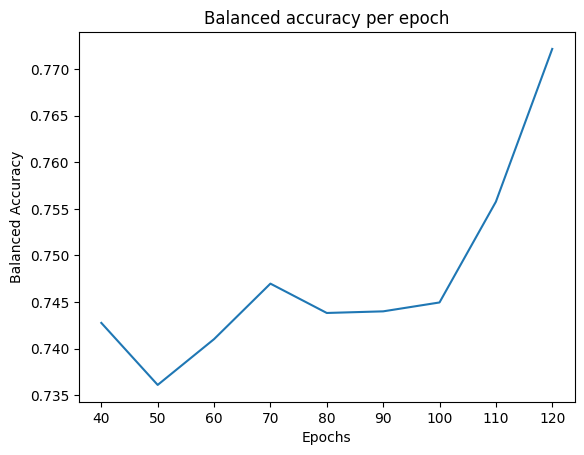

In [11]:
plt.plot(list(balanced_acc_1.keys()), [val[0] for key, val in balanced_acc_1.items()])
plt.xlabel("Epochs")
plt.ylabel("Balanced Accuracy")
plt.title("Balanced accuracy per epoch")
plt.show()

In [36]:
best_balanced_accuracy_overall = {}
for epoch, diffs in all_diffs.items():
    acutal,_ = all_actual_predictions[epoch]
    epoch_best_balanced_accuracy = (0,1000);
    print("Test evey cutoff for epoch: ", epoch)
    for class_cutoff in range(1000,4000):
        new_pres = [None] * len(actual)
        for idx, diff in enumerate(diffs):
            if diff < class_cutoff:
                new_pres[idx]= "notrash"
            else:
                new_pres[idx]= "trash"
        true_pos, true_neg, false_pos, false_neg = calculate_submetrics(acutal, new_pres)
        ba = balanced_accuracy(false_pos, true_pos, true_neg, false_neg)
        if ba < epoch_best_balanced_accuracy[1]:
            epoch_best_balanced_accuracy = (class_cutoff, ba)

    best_balanced_accuracy_overall[epoch] = epoch_best_balanced_accuracy
    print(f"best balanced_accuracy for epoch {epoch}:", epoch_best_balanced_accuracy)

best_balanced_accuracy_overall

Test evey cutoff for epoch:  10
best balanced_accuracy for epoch 10: (3987, 0.8962298506149176)
Test evey cutoff for epoch:  20
best balanced_accuracy for epoch 20: (3995, 0.8333773571404126)
Test evey cutoff for epoch:  30
best balanced_accuracy for epoch 30: (3999, 0.8159547282622421)
Test evey cutoff for epoch:  40
best balanced_accuracy for epoch 40: (3999, 0.7721703034136389)
Test evey cutoff for epoch:  50
best balanced_accuracy for epoch 50: (3999, 0.7557586966910035)
Test evey cutoff for epoch:  60
best balanced_accuracy for epoch 60: (3996, 0.7449484021990884)
Test evey cutoff for epoch:  70
best balanced_accuracy for epoch 70: (3999, 0.7442516343624976)
Test evey cutoff for epoch:  80
best balanced_accuracy for epoch 80: (3993, 0.7438202506351717)
Test evey cutoff for epoch:  90
best balanced_accuracy for epoch 90: (3999, 0.7471495265456891)
Test evey cutoff for epoch:  100
best balanced_accuracy for epoch 100: (3999, 0.7412610054374997)
Test evey cutoff for epoch:  110
best 

{10: (3987, 0.8962298506149176),
 20: (3995, 0.8333773571404126),
 30: (3999, 0.8159547282622421),
 40: (3999, 0.7721703034136389),
 50: (3999, 0.7557586966910035),
 60: (3996, 0.7449484021990884),
 70: (3999, 0.7442516343624976),
 80: (3993, 0.7438202506351717),
 90: (3999, 0.7471495265456891),
 100: (3999, 0.7412610054374997),
 110: (3996, 0.7363390807087467),
 120: (3999, 0.7427536643728815)}

#### Validation with models trained for different epochs (ignorance_threshold = 0.2)

In [12]:
all_actual_predictions, all_diffs_categorized, all_diffs = run_validation(ignorance_threshold=4.0)


testing for model:  ./vae_v4_saved_models/model_epoch_full40.pth
168it [00:11, 14.71it/s]
testing for model:  ./vae_v4_saved_models/model_epoch_full50.pth
168it [00:11, 14.74it/s]
testing for model:  ./vae_v4_saved_models/model_epoch_full60.pth
92it [00:06, 14.67it/s]
168it [00:11, 14.71it/s]
testing for model:  ./vae_v4_saved_models/model_epoch_full70.pth
168it [00:11, 14.70it/s]
testing for model:  ./vae_v4_saved_models/model_epoch_full80.pth
168it [00:11, 14.36it/s]
testing for model:  ./vae_v4_saved_models/model_epoch_full90.pth
168it [00:11, 14.36it/s]
testing for model:  ./vae_v4_saved_models/model_epoch_full100.pth
168it [00:11, 14.65it/s]
testing for model:  ./vae_v4_saved_models/model_epoch_full110.pth
168it [00:11, 14.67it/s]
testing for model:  ./vae_v4_saved_models/model_epoch_full120.pth
168it [00:11, 14.69it/s]



In [20]:
balanced_acc_2 = calculate_metrics(all_actual_predictions)
balanced_acc_2


{40: (0.6327536643728815, 1201, 1019, 5839, 343),
 50: (0.656094770289095, 1356, 1020, 5586, 355),
 60: (0.6520204147520966, 1321, 1018, 5628, 333),
 70: (0.6385746710149272, 1206, 993, 5865, 338),
 80: (0.6338202506351717, 1272, 1012, 5830, 366),
 90: (0.643993794660057, 1223, 998, 5875, 342),
 100: (0.6388884021990884, 1204, 992, 5866, 365),
 110: (0.6657586966910035, 1203, 900, 6004, 312),
 120: (0.6921707294136389, 1286, 848, 6031, 307)
 }


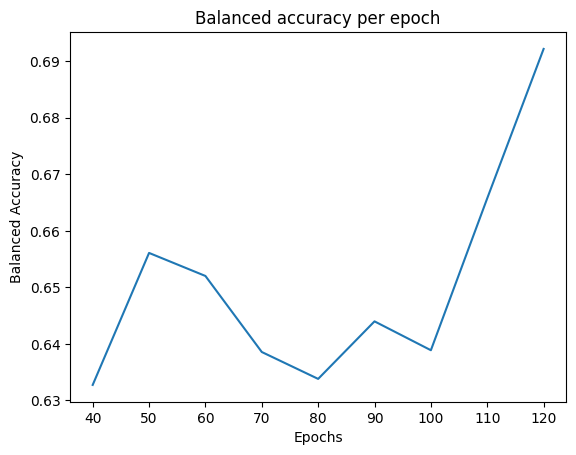

In [21]:
plt.plot(list(balanced_acc_2.keys()), [val[0] for key, val in balanced_acc_2.items()])
plt.xlabel("Epochs")
plt.ylabel("Balanced Accuracy")
plt.title("Balanced accuracy per epoch")
plt.show()